In [1]:
# !pip install --upgrade pip
# !pip install --upgrade torch torchvision

In [2]:
# PyTorch and torchvision
import torch
import torchvision

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print('=3')

=3


In [3]:
# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
!wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ~/work/data_augmentation/data
!tar -xf ~/work/data_augmentation/data/images.tar -C ~/work/data_augmentation/data/

--2026-01-22 08:03:57--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘/home/jovyan/work/data_augmentation/data/images.tar.3’

images.tar.3        100%[===================>] 756.82M  13.9MB/s    in 59s     

2026-01-22 08:04:57 (12.7 MB/s) - ‘/home/jovyan/work/data_augmentation/data/images.tar.3’ saved [793579520/793579520]



In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

dataset_dir = "~/work/data_augmentation/data/Images/"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])
full_dataset = ImageFolder(root=dataset_dir, transform=transform)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # 약 12,000개
test_size = total_size - train_size   # 약 8,580개
ds_train, ds_test = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=32, shuffle=False)
ds_info = {
    "num_classes": len(full_dataset.classes),
    "class_names": full_dataset.classes
}

print("=3")

=3


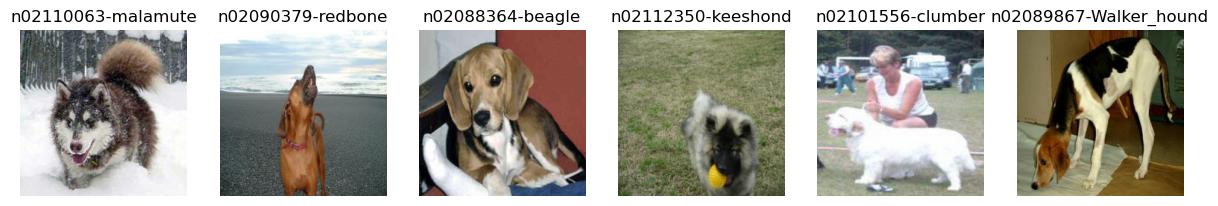

In [6]:
# DataLoader에서 일부 배치 가져오기
def show_examples(data_loader, class_names, num_images=6):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
        image = (image * 0.5) + 0.5
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(class_names[labels[i].item()])

    plt.show()

# 훈련 데이터 샘플 시각화
show_examples(train_loader, ds_info["class_names"])

In [7]:
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
    ])

In [8]:
def augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2)
    ])

print('=3')

=3


In [9]:
# 데이터셋을 가공하는 메인함수
def apply_normalize_on_dataset(dataset, is_test=False, batch_size=16, with_aug=False):
    transform = normalize_and_resize_img()

    if not is_test and with_aug:
        dataset.dataset.transform = transforms.Compose([
            *augment().transforms,
            *transform.transforms
        ])
    else:
        dataset.dataset.transform = transform

    return DataLoader(dataset, batch_size=batch_size, shuffle=not is_test, num_workers=2, pin_memory=True)

print('=3')

=3


In [10]:
import random

def augment2():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.RandomRotation(degrees=(0, 90, 180, 270)),  # 90도 단위 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # 밝기, 대비, 색상 조정
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 랜덤 크롭 후 리사이즈
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 0~1 값으로 클리핑
    ])

print('=3')

=3


In [11]:
import torch.nn as nn
import torchvision.models as models

num_classes = len(ds_info["class_names"])
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

model = nn.Sequential(
    resnet50,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(resnet50.fc.in_features, num_classes),
    nn.Softmax(dim=1)
)

print("=3")


=3


In [12]:
aug_resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
aug_resnet50.fc = nn.Linear(aug_resnet50.fc.in_features, num_classes)

aug_resnet50 = nn.Sequential(
    aug_resnet50,
    nn.Softmax(dim=1)
)

print("=3")

=3


In [13]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

print("=3")

=3


In [14]:
import numpy as np
import torch

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam



In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

In [16]:
def cutmix_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    y_a, y_b = y, y[index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    mixed_x = x.clone()
    mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return mixed_x, y_a, y_b, lam

In [17]:
# 모델을 매번 새로 만들기 위한 함수
def get_fresh_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    # 모델 구조 (Softmax 포함 여부에 따라 조정, CrossEntropyLoss 사용 시 보통 Softmax 제외)
    # 여기서는 사용자 코드와의 호환성을 위해 간단히 정의
    return model

In [18]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
import torch.optim as optim
# 결과 저장을 위한 딕셔너리
history_db = {}
EPOCH = 5  # 시간 관계상 5 Epoch (원하시는 대로 조절 가능)

# 실험 케이스 정의
experiments = [
    # (실험명, 데이터로더, 증강기법)
    ("No Augmentation", ds_train_no_aug, 'none'),
    ("Basic Augmentation", ds_train_aug, 'none'),
    ("Basic + Mixup", ds_train_aug, 'mixup'),
    ("Basic + CutMix", ds_train_aug, 'cutmix')
]

print(f"=== 실험 시작 (Total Epochs: {EPOCH}) ===")

for exp_name, train_loader_selected, method in experiments:
    print(f"\n[Experiment] {exp_name} 진행 중...")
    
    # 1. 모델 초기화 (매 실험마다 가중치 리셋)
    model = get_fresh_model(len(ds_info["class_names"]))
    model.to(device)
    
    # 2. Optimizer, Loss 초기화
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    # 3. 사용자 정의 Train 함수 실행 (내부 로직은 작성하신 코드와 동일하다고 가정)
    # 단, train 함수 안에서 optimizer와 criterion을 외부 변수를 쓰지 않고 인자로 받거나 
    # 위에서 정의한 전역 변수를 쓰도록 주의해야 합니다.
    
    # (여기서 사용자님의 train 함수 로직을 그대로 수행합니다)
    # 편의상 train 함수가 history 딕셔너리를 리턴한다고 가정합니다.
    
    # === Train Loop (사용자님 코드 로직 통합) ===
    history = {'val_accuracy': []}
    for epoch in range(EPOCH):
        model.train()
        correct = 0; total = 0
        for images, labels in train_loader_selected:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            if method == 'mixup':
                images, targets_a, targets_b, lam = mixup_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            elif method == 'cutmix':
                images, targets_a, targets_b, lam = cutmix_data(images, labels)
                outputs = model(images)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_correct = 0; val_total = 0
        with torch.no_grad():
            for images, labels in ds_test: # ds_test는 항상 동일
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        history['val_accuracy'].append(val_acc)
        print(f"  Epoch {epoch+1}/{EPOCH} | Val Acc: {val_acc:.2f}%")
    
    # 결과 저장
    history_db[exp_name] = history['val_accuracy']

print("\n=== 모든 실험 완료 ===")

=== 실험 시작 (Total Epochs: 5) ===

[Experiment] No Augmentation 진행 중...
  Epoch 1/5 | Val Acc: 77.45%
  Epoch 2/5 | Val Acc: 79.39%
  Epoch 3/5 | Val Acc: 78.75%
  Epoch 4/5 | Val Acc: 81.00%
  Epoch 5/5 | Val Acc: 81.81%

[Experiment] Basic Augmentation 진행 중...
  Epoch 1/5 | Val Acc: 77.22%
  Epoch 2/5 | Val Acc: 79.84%
  Epoch 3/5 | Val Acc: 82.20%
  Epoch 4/5 | Val Acc: 81.71%
  Epoch 5/5 | Val Acc: 80.97%

[Experiment] Basic + Mixup 진행 중...
  Epoch 1/5 | Val Acc: 72.99%
  Epoch 2/5 | Val Acc: 77.91%
  Epoch 3/5 | Val Acc: 80.06%
  Epoch 4/5 | Val Acc: 78.94%
  Epoch 5/5 | Val Acc: 80.52%

[Experiment] Basic + CutMix 진행 중...
  Epoch 1/5 | Val Acc: 74.27%
  Epoch 2/5 | Val Acc: 78.93%
  Epoch 3/5 | Val Acc: 80.11%
  Epoch 4/5 | Val Acc: 81.36%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for exp_name, acc_list in history_db.items():
    plt.plot(acc_list, label=exp_name)

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Mixup/CutMix의 특징: 초반 Epoch에는 기본 Augmentation보다 성능이 낮게 나올 수 있습니다 (데이터가 어렵기 때문). 하지만 Epoch을 길게(예: 20~50회 이상) 가져갈수록, 그리고 과적합이 발생할 시점에서 더 높은 성능을 보여주는 경향이 있습니다.

No Augmentation: 가장 빠르게 학습되지만, 가장 빨리 과적합(Validation Acc 정체)될 것입니다

In [ ]:

%%time
history_mixup = train(resnet50, train_loader, test_loader, EPOCH, aug_method='mixup')


In [ ]:
%%time
history_cutmix = train(resnet50, train_loader, test_loader, EPOCH, aug_method='cutmix')

In [ ]:

plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug['val_accuracy'], 'r', label='No Augmentation')
plt.plot(history_resnet50_aug['val_accuracy'], 'b', label='With Augmentation')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

In [ ]:
history_mixup.eval()
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = history_mixup(images)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. imshow 헬퍼 함수 정의 (이미지를 시각화 가능한 형태로 변환)
def imshow(tensor):
    image = tensor.cpu().clone()  # 텐서를 CPU로 복사
    image = image.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)
    image = image.numpy()  # Numpy 배열로 변환
    
    # 정규화 해제 (Normalize에서 사용한 mean, std 값에 맞춰 역연산)
    # 앞선 transform에서 mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]를 사용했다고 가정
    image = image * 0.5 + 0.5 
    image = np.clip(image, 0, 1)  # 0~1 사이 값으로 클리핑
    return image

In [ ]:

# 'binary-category'는 일반적으로 0:cat, 1:dog을 나타냅니다.
binary_labels_map = ['cat', 'dog']
# 2. 예측 결과 시각화 함수 (버그 수정됨)
def display_predictions(loader, model, class_names, device, n_images=9):
    dataiter = iter(loader)
    images, labels = next(dataiter) # 배치 가져오기

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.flatten()

    model.eval() # 평가 모드 설정

    with torch.no_grad():
        for i in range(n_images):
            if i >= len(images):
                break

            ax = axes[i]
            
            # 이미지 변환 및 출력
            img = imshow(images[i]) 
            ax.imshow(img)

            # 모델 예측
            # unsqueeze(0): (C, H, W) -> (1, C, H, W)로 배치 차원 추가
            outputs = model(images[i].unsqueeze(0).to(device))
            
            # 예측값 추출
            _, predicted = torch.max(outputs.data, 1)
            predicted_idx = predicted.item()
            predicted_class_name = class_names[predicted_idx]

            # 실제 라벨 추출 (수정된 부분: labels -> labels[i])
            true_label_idx = labels[i].item()
            true_class_name = class_names[true_label_idx]

            # 결과 텍스트 설정 (True가 초록색, 틀리면 빨간색)
            color = 'green' if predicted_idx == true_label_idx else 'red'
            
            ax.set_title(f"True: {true_class_name}\nPred: {predicted_class_name}", 
                         color=color, fontsize=12)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# display_predictions(test_loader, resnet50, ds_info["class_names"], device, n_images=9)

In [ ]:
display_predictions(test_loader, resnet50, ds_info["class_names"], device, n_images=9)

In [ ]:
display_predictions(test_loader, aug_resnet50, ds_info["class_names"], device, n_images=9)

In [ ]:
display_predictions(test_loader, history_mixup, ds_info["class_names"], device, n_images=9)

In [ ]:
display_predictions(test_loader, history_cutmix, ds_info["class_names"], device, n_images=9)

In [ ]:
display_predictions

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def mixup_data_soft(x, y, num_classes, alpha=1.0, device='cuda'):
    '''
    Returns: mixed_x, mixed_y (Soft Labels)
    '''
    # 1. Lambda값 생성
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    # 2. 이미지 섞기
    mixed_x = lam * x + (1 - lam) * x[index, :]

    # 3. 라벨 섞기 (Sparse -> One-Hot -> Mixed)
    # y가 정수형(Sparse)이므로 One-Hot으로 변환
    y_onehot = F.one_hot(y, num_classes=num_classes).float()
    
    # 섞인 라벨 계산 (예: 0.7*Cat + 0.3*Dog)
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index, :]

    return mixed_x, mixed_y

In [ ]:
def train_categorical(model, train_loader, test_loader, epochs, aug_method='none'):
    model.to(device)
    
    # Keras의 categorical_crossentropy와 동일한 역할
    # (Softmax가 포함되어 있으므로 모델 끝에 Softmax를 또 붙이면 안 됩니다!)
    criterion = nn.CrossEntropyLoss() 
    
    optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
    
    print(f"Start training with method: {aug_method} (Explicit Categorical)")

    for epoch in range(epochs):
        model.train()
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # --- [수정된 부분] ---
            if aug_method == 'mixup':
                # 라벨을 섞어서 받아옴 (mixed_labels는 이제 [0.7, 0.3, ...] 형태)
                images, mixed_labels = mixup_data_soft(images, labels, num_classes=120, device=device)
                
                outputs = model(images)
                
                # 명시적 Categorical CrossEntropy 계산
                loss = criterion(outputs, mixed_labels)
                
            else:
                # 일반 학습 (Sparse Label 사용)
                outputs = model(images)
                loss = criterion(outputs, labels)
            # --------------------

            loss.backward()
            optimizer.step()

            # 정확도 계산 (Soft Label인 경우 가장 높은 확률의 인덱스를 정답으로 간주)
            _, predicted = outputs.max(1)
            
            # Mixup일 때는 라벨도 확률값이므로 argmax를 취해 비교하거나, 
            # 원본 라벨을 따로 저장해서 비교해야 정확하지만, 
            # 여기서는 학습 진행 확인용으로 예측값 분포만 봅니다.
            if aug_method == 'mixup':
                _, target_idx = mixed_labels.max(1) # 가장 비중이 높은 클래스를 정답으로
                total += labels.size(0)
                correct += predicted.eq(target_idx).sum().item()
            else:
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        train_acc = 100. * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Method: {aug_method}, Train Acc: {train_acc:.2f}%")
        
        # (검증 코드는 기존과 동일하여 생략, 필요시 추가)
        
    return "Training Finished"

# 실행 예시
# ds_info["num_classes"] 값을 정확히 넣어주세요 (여기선 120으로 가정)
# train_categorical(resnet50, train_loader, test_loader, EPOCH, aug_method='mixup')